In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, VGG16, ResNet50
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
IMG_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.01
VALIDATION_SPLIT = 0.2

In [34]:
# Set your dataset path
DATASET_PATH = "/kaggle/input/butterfly-image-classification"
TRAIN_IMG_DIR = os.path.join(DATASET_PATH, "train")
TEST_IMG_DIR = os.path.join(DATASET_PATH, "test")
TRAIN_CSV = os.path.join(DATASET_PATH, "Training_set.csv")
TEST_CSV = os.path.join(DATASET_PATH, "Testing_set.csv")

In [35]:
# Check if files exist
paths_to_check = [TRAIN_IMG_DIR, TEST_IMG_DIR, TRAIN_CSV, TEST_CSV]
for path in paths_to_check:
    if os.path.exists(path):
        print(f"✓ {path} exists")
    else:
        print(f"✗ {path} not found")

✓ /kaggle/input/butterfly-image-classification/train exists
✓ /kaggle/input/butterfly-image-classification/test exists
✓ /kaggle/input/butterfly-image-classification/Training_set.csv exists
✓ /kaggle/input/butterfly-image-classification/Testing_set.csv exists


In [36]:
# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [37]:
print(f"\nTraining CSV shape: {train_df.shape}")
print(f"Testing CSV shape: {test_df.shape}")
print(f"\nTraining CSV columns: {train_df.columns.tolist()}")
print(f"Testing CSV columns: {test_df.columns.tolist()}")


Training CSV shape: (6499, 2)
Testing CSV shape: (2786, 1)

Training CSV columns: ['filename', 'label']
Testing CSV columns: ['filename']


In [38]:
print("\nFirst 5 rows of Training CSV:")
print(train_df.head())


First 5 rows of Training CSV:
      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART


In [39]:
# Cell 4: Data Exploration and Analysis
# Analyze the dataset
print("Dataset Analysis:")
print(f"Total training images: {len(train_df)}")
print(f"Total test images: {len(test_df)}")

Dataset Analysis:
Total training images: 6499
Total test images: 2786


In [40]:
# Get unique labels and their counts
label_counts = train_df['label'].value_counts()
print(f"\nNumber of unique classes: {len(label_counts)}")
print(f"Class distribution:")
print(label_counts.head(10))


Number of unique classes: 75
Class distribution:
label
MOURNING CLOAK              131
SLEEPY ORANGE               107
ATALA                       100
BROWN SIPROETA               99
CRECENT                      97
SCARCE SWALLOW               97
BANDED ORANGE HELICONIAN     97
MILBERTS TORTOISESHELL       96
RED CRACKER                  96
ORANGE TIP                   96
Name: count, dtype: int64


In [41]:
# Check for missing values
print(f"\nMissing values in training data:")
print(train_df.isnull().sum())


Missing values in training data:
filename    0
label       0
dtype: int64


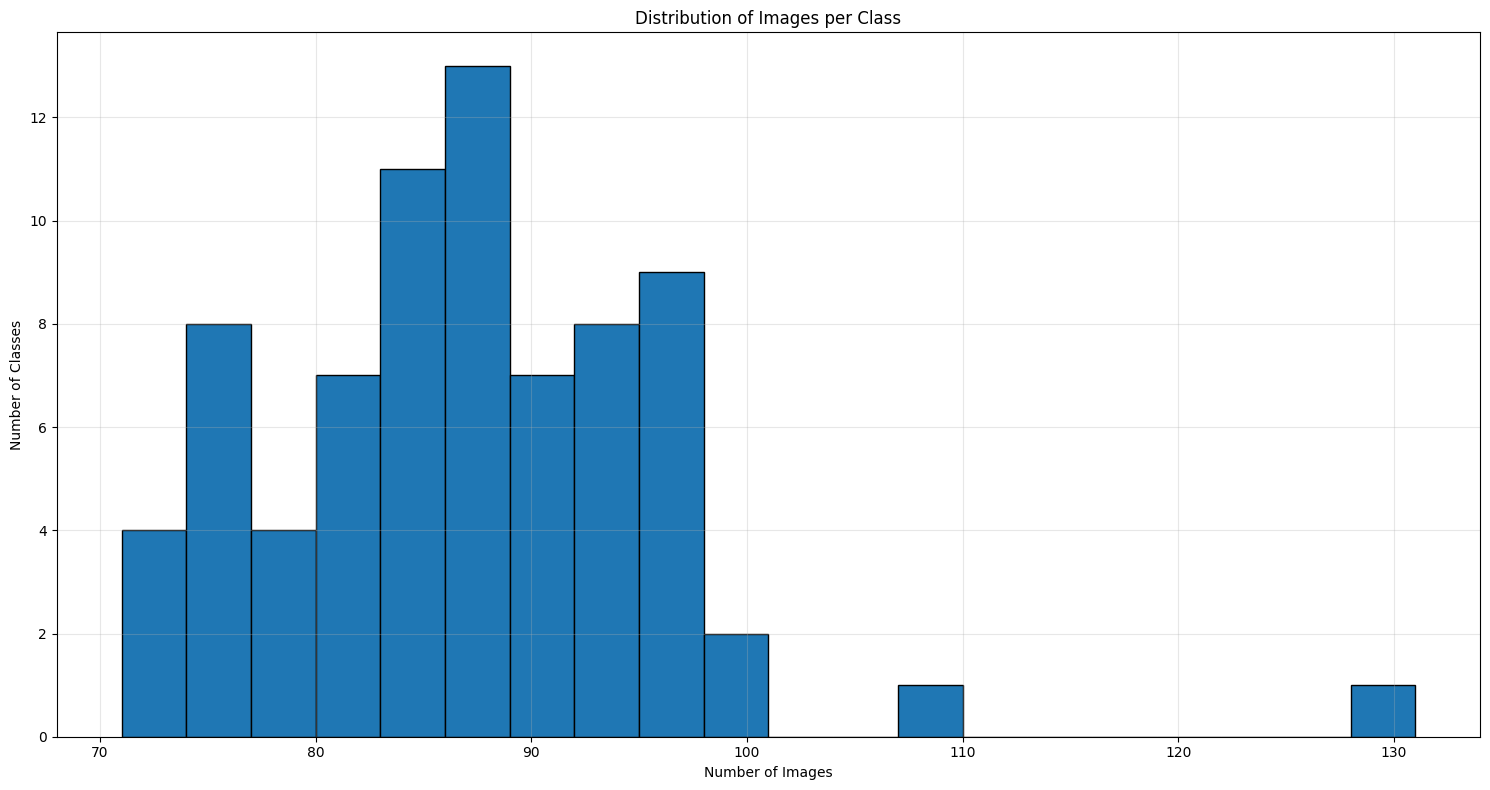

In [42]:
# Cell 5: Visualize Class Distribution
plt.figure(figsize=(15, 8))
if len(label_counts) <= 20:
    # Show all classes if <= 20
    plt.bar(label_counts.index, label_counts.values)
    plt.title('Training Data Distribution by Class')
    plt.xlabel('Butterfly Species')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
else:
    # Show histogram for large number of classes
    plt.hist(label_counts.values, bins=20, edgecolor='black')
    plt.title('Distribution of Images per Class')
    plt.xlabel('Number of Images')
    plt.ylabel('Number of Classes')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [43]:
# Cell 6: Data Preprocessing - Create Label Encoder
# Create label encoder
label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])

# Get class information
classes = label_encoder.classes_
num_classes = len(classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {classes[:10]}...")  # Show first 10 classes

# Create class to index mapping
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for idx, cls in enumerate(classes)}

Number of classes: 75
Classes: ['ADONIS' 'AFRICAN GIANT SWALLOWTAIL' 'AMERICAN SNOOT' 'AN 88' 'APPOLLO'
 'ATALA' 'BANDED ORANGE HELICONIAN' 'BANDED PEACOCK' 'BECKERS WHITE'
 'BLACK HAIRSTREAK']...


In [44]:
# Cell 7: Verify Image Files Exist
def verify_images(df, img_dir, filename_col='filename'):
    """Verify that image files exist in the directory"""
    missing_files = []
    existing_files = []
    
    for idx, row in df.iterrows():
        img_path = os.path.join(img_dir, row[filename_col])
        if os.path.exists(img_path):
            existing_files.append(img_path)
        else:
            missing_files.append(row[filename_col])
    
    print(f"Existing files: {len(existing_files)}")
    print(f"Missing files: {len(missing_files)}")
    
    if missing_files:
        print(f"First 5 missing files: {missing_files[:5]}")
    
    return existing_files, missing_files

In [45]:
# Verify training images
train_existing, train_missing = verify_images(train_df, TRAIN_IMG_DIR, 'filename')


Existing files: 6499
Missing files: 0


In [46]:
# Cell 8: Split Training Data into Train and Validation
# Split the training data into train and validation sets
train_data, val_data = train_test_split(
    train_df, 
    test_size=VALIDATION_SPLIT, 
    stratify=train_df['label_encoded'], 
    random_state=42
)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

# Reset indices
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

Training set size: 5199
Validation set size: 1300


In [47]:
# Cell 9: Custom Data Generator Class
class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, dataframe, img_dir, batch_size, img_size, 
                 label_encoder=None, augment=False, shuffle=True):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.label_encoder = label_encoder
        self.augment = augment
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataframe))
        
        # Data augmentation
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.dataframe))
        batch_indices = self.indices[start_idx:end_idx]
        
        return self._generate_batch(batch_indices)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def _generate_batch(self, batch_indices):
        batch_x = np.empty((len(batch_indices), self.img_size, self.img_size, 3))
        batch_y = np.empty((len(batch_indices), num_classes))
        
        for i, idx in enumerate(batch_indices):
            row = self.dataframe.iloc[idx]
            
            # Load image
            img_path = os.path.join(self.img_dir, row['filename'])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img / 255.0
            
            # Apply augmentation if enabled
            if self.augment:
                img = img.reshape((1,) + img.shape)
                img = self.datagen.flow(img, batch_size=1)[0][0]
            
            batch_x[i] = img
            
            # One-hot encode labels
            if 'label_encoded' in row:
                batch_y[i] = to_categorical(row['label_encoded'], num_classes)
        
        return batch_x, batch_y

In [48]:
# Cell 10: Create Data Generators
# Create data generators
train_generator = CustomDataGenerator(
    train_data, TRAIN_IMG_DIR, BATCH_SIZE, IMG_SIZE, 
    label_encoder, augment=True, shuffle=True
)

val_generator = CustomDataGenerator(
    val_data, TRAIN_IMG_DIR, BATCH_SIZE, IMG_SIZE, 
    label_encoder, augment=False, shuffle=False
)

print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(val_generator)}")

Training batches: 82
Validation batches: 21


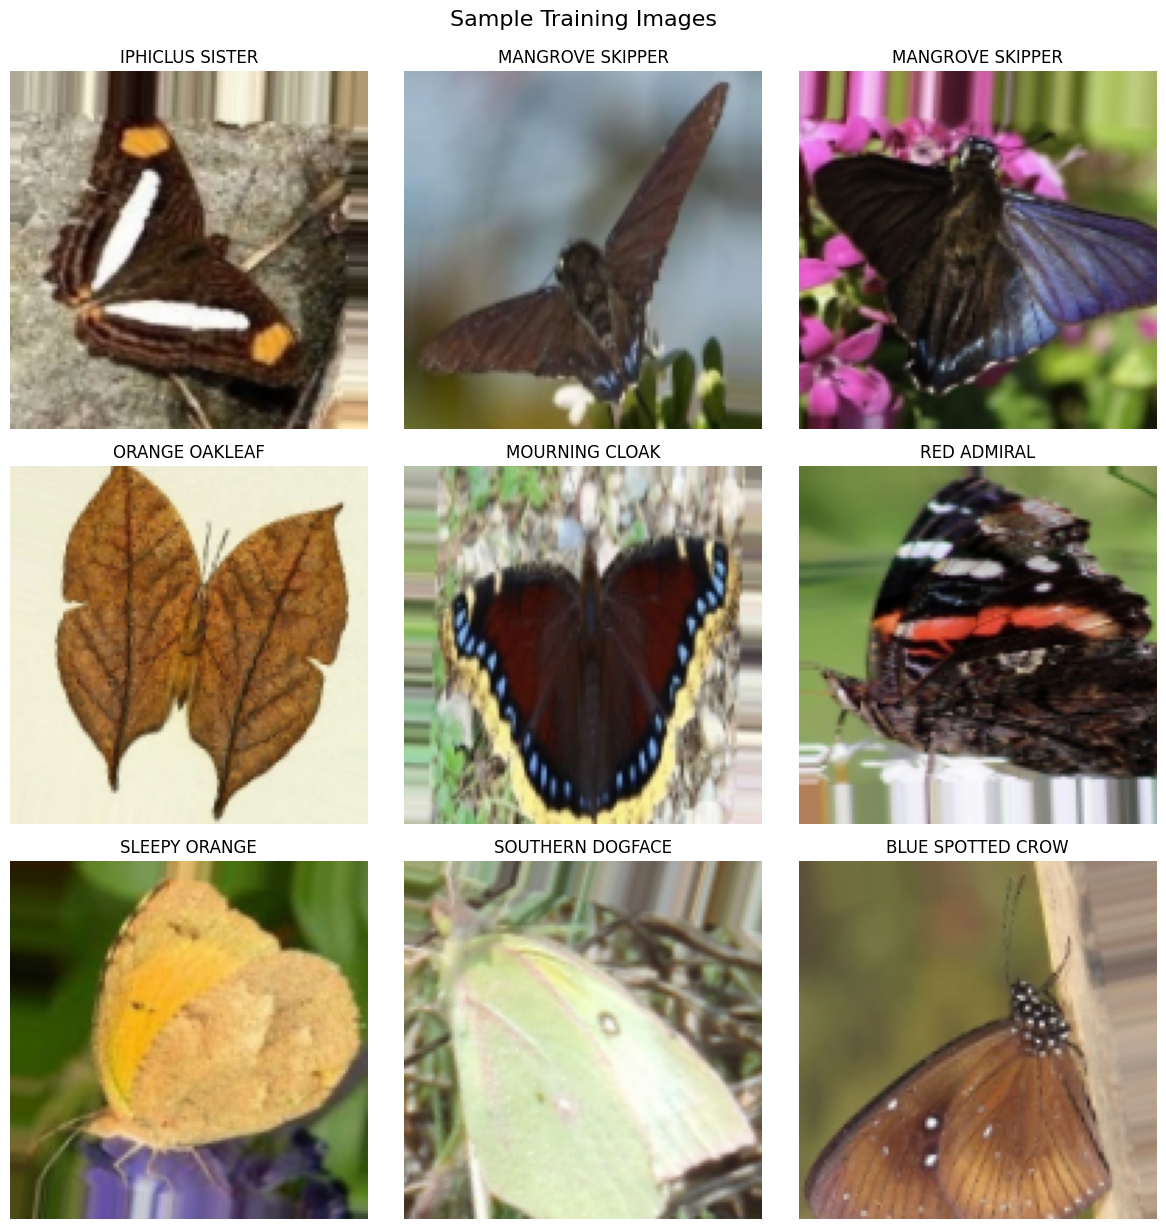

In [49]:
# Cell 11: Display Sample Images
def display_sample_images_from_generator(generator, class_names, num_samples=9):
    """Display sample images from the generator"""
    batch_x, batch_y = generator[0]
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(batch_x))):
        img = batch_x[i]
        label_idx = np.argmax(batch_y[i])
        class_name = class_names[label_idx]
        
        axes[i].imshow(img)
        axes[i].set_title(f'{class_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample Training Images', fontsize=16, y=1.02)
    plt.show()

# Display sample images
display_sample_images_from_generator(train_generator, classes)

In [50]:
def create_model(base_model_name='vgg16', num_classes=num_classes):
    """Create transfer learning model"""
    
    # Choose base model
    if base_model_name == 'vgg16':
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
    elif base_model_name == 'efficientnet':
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
    elif base_model_name == 'resnet50':
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Create model
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

In [51]:
# Create model
model, base_model = create_model('vgg16', num_classes)

In [52]:
# Cell 12: Model Architecture - EfficientNetB0 with Transfer Learning
from tensorflow.keras.metrics import TopKCategoricalAccuracy

In [53]:
# Compile model
model.compile(
    optimizer=Nadam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

In [54]:
# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 75)                  │          19,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,131,019 (57.72 MB)

 Trainable params: 414,795 (1.58 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [55]:
# Cell 13: Callbacks for Training
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_butterfly_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]



In [56]:
# Cell 14: Model Training (Phase 1 - Frozen Base Model)
print("Phase 1: Training with frozen base model")
history_phase1 = model.fit(
    train_generator,
    epochs=5,
    steps_per_epoch=50,  # Add this line
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Phase 1: Training with frozen base model
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0761 - loss: 4.4968 - top_5_accuracy: 0.2179
Epoch 1: val_accuracy improved from -inf to 0.15231, saving model to best_butterfly_model.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 469s 9s/step - accuracy: 0.0773 - loss: 4.4854 - top_5_accuracy: 0.2204 - val_accuracy: 0.1523 - val_loss: 4.4014 - val_top_5_accuracy: 0.3923 - learning_rate: 0.0100
Epoch 2/5
32/50 ━━━━━━━━━━━━━━━━━━━━ 2:00 7s/step - accuracy: 0.2475 - loss: 2.9379 - top_5_accuracy: 0.5712
Epoch 2: val_accuracy improved from 0.15231 to 0.31462, saving model to best_butterfly_model.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 348s 7s/step - accuracy: 0.2573 - loss: 2.9024 - top_5_accuracy: 0.5786 - val_accuracy: 0.3146 - val_loss: 2.6587 - val_top_5_accuracy: 0.6685 - learning_rate: 0.0100
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3592 - loss: 2.4388 - top_5_accuracy: 0.6886
Epoch 3: val_accuracy improved from 0.31462 to 0.39692, sav

In [62]:
# Cell 15: Fine-tuning (Phase 2 - Unfreeze Top Layers)
print("Phase 2: Fine-tuning with unfrozen top layers")

# Unfreeze top layers of base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers) - 20

# Freeze all layers except the top ones
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Phase 2: Fine-tuning with unfrozen top layers


In [63]:
# # Recompile with lower learning rate
# model.compile(
#     optimizer=Nadam(learning_rate=LEARNING_RATE/10),
#     loss='categorical_crossentropy',
#     metrics=['accuracy',TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]   
    
# )

In [69]:
# Recompile with lower learning rate
model.compile(
    optimizer=Nadam(learning_rate=LEARNING_RATE/10),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

# Continue training
history_phase2 = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=50,  # Add this line
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=len(history_phase1.history['loss'])
)

Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4766 - loss: 1.8602 - top_5_accuracy: 0.8077
Epoch 6: val_accuracy improved from 0.56077 to 0.63923, saving model to best_butterfly_model.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 471s 9s/step - accuracy: 0.4766 - loss: 1.8601 - top_5_accuracy: 0.8077 - val_accuracy: 0.6392 - val_loss: 1.3183 - val_top_5_accuracy: 0.8877 - learning_rate: 0.0010
Epoch 7/10
32/50 ━━━━━━━━━━━━━━━━━━━━ 2:01 7s/step - accuracy: 0.4887 - loss: 1.8450 - top_5_accuracy: 0.8131
Epoch 7: val_accuracy improved from 0.63923 to 0.66692, saving model to best_butterfly_model.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 358s 7s/step - accuracy: 0.4938 - loss: 1.8348 - top_5_accuracy: 0.8131 - val_accuracy: 0.6669 - val_loss: 1.2779 - val_top_5_accuracy: 0.8962 - learning_rate: 0.0010
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4855 - loss: 1.8607 - top_5_accuracy: 0.8058
Epoch 8: val_accuracy did not improve from 0.66692
50/50 ━━━━━━━━━━━━━━━━━━━━ 472s 9s/step - a

In [70]:
# Cell 16: Combine Training Histories
def combine_histories(hist1, hist2):
    """Combine two training histories"""
    combined_history = {}
    for key in hist1.history.keys():
        combined_history[key] = hist1.history[key] + hist2.history[key]
    return combined_history

# Combine histories
combined_history = combine_histories(history_phase1, history_phase2)

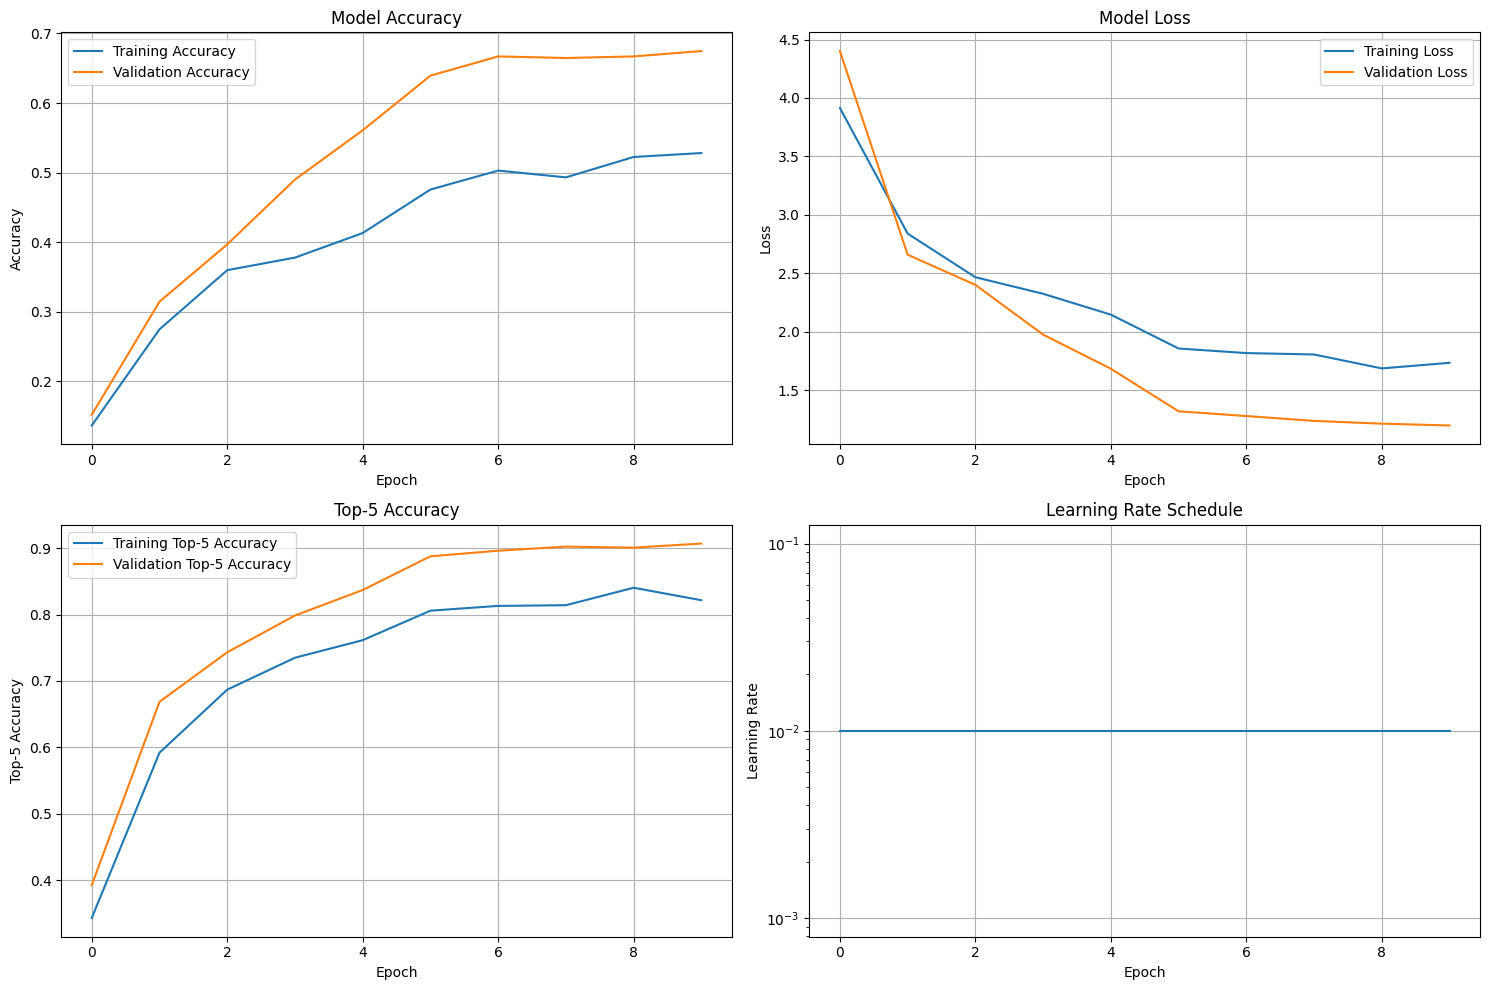

In [71]:
# Cell 17: Training Visualization
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history['loss'], label='Training Loss')
    axes[0, 1].plot(history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Top-5 Accuracy
    axes[1, 0].plot(history['top_5_accuracy'], label='Training Top-5 Accuracy')
    axes[1, 0].plot(history['val_top_5_accuracy'], label='Validation Top-5 Accuracy')
    axes[1, 0].set_title('Top-5 Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Top-5 Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning Rate Schedule
    axes[1, 1].plot(range(len(history['loss'])), [LEARNING_RATE] * len(history['loss']))
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(combined_history)


In [72]:
# Cell 18: Model Evaluation on Validation Set
# Load best model
model.load_weights('best_butterfly_model.h5')

In [73]:
# Evaluate on validation set
val_loss, val_accuracy, val_top5_accuracy = model.evaluate(val_generator, verbose=1)

print(f"\nValidation Results:")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Top-5 Accuracy: {val_top5_accuracy:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.6650 - loss: 1.2232 - top_5_accuracy: 0.9072

Validation Results:
Validation Loss: 1.1969
Validation Accuracy: 0.6746
Validation Top-5 Accuracy: 0.9069


In [74]:
# Cell 19: Generate Predictions for Validation Set
# Get predictions on validation set
val_predictions = model.predict(val_generator, verbose=1)
val_predicted_classes = np.argmax(val_predictions, axis=1)
val_true_classes = val_data['label_encoded'].values

# Classification report
print("\nClassification Report (Validation Set):")
print(classification_report(val_true_classes, val_predicted_classes, 
                          target_names=classes, 
                          zero_division=0))

21/21 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step

Classification Report (Validation Set):
                           precision    recall  f1-score   support

                   ADONIS       0.72      0.72      0.72        18
AFRICAN GIANT SWALLOWTAIL       0.92      0.80      0.86        15
           AMERICAN SNOOT       0.50      0.53      0.52        15
                    AN 88       1.00      1.00      1.00        17
                  APPOLLO       0.82      0.78      0.80        18
                    ATALA       0.58      0.75      0.65        20
 BANDED ORANGE HELICONIAN       0.78      0.90      0.84        20
           BANDED PEACOCK       0.86      0.71      0.77        17
            BECKERS WHITE       0.79      0.69      0.73        16
         BLACK HAIRSTREAK       0.34      0.65      0.45        17
              BLUE MORPHO       0.78      0.47      0.58        15
        BLUE SPOTTED CROW       0.65      0.88      0.75        17
           BROWN SIPROETA       0.71      0.60 

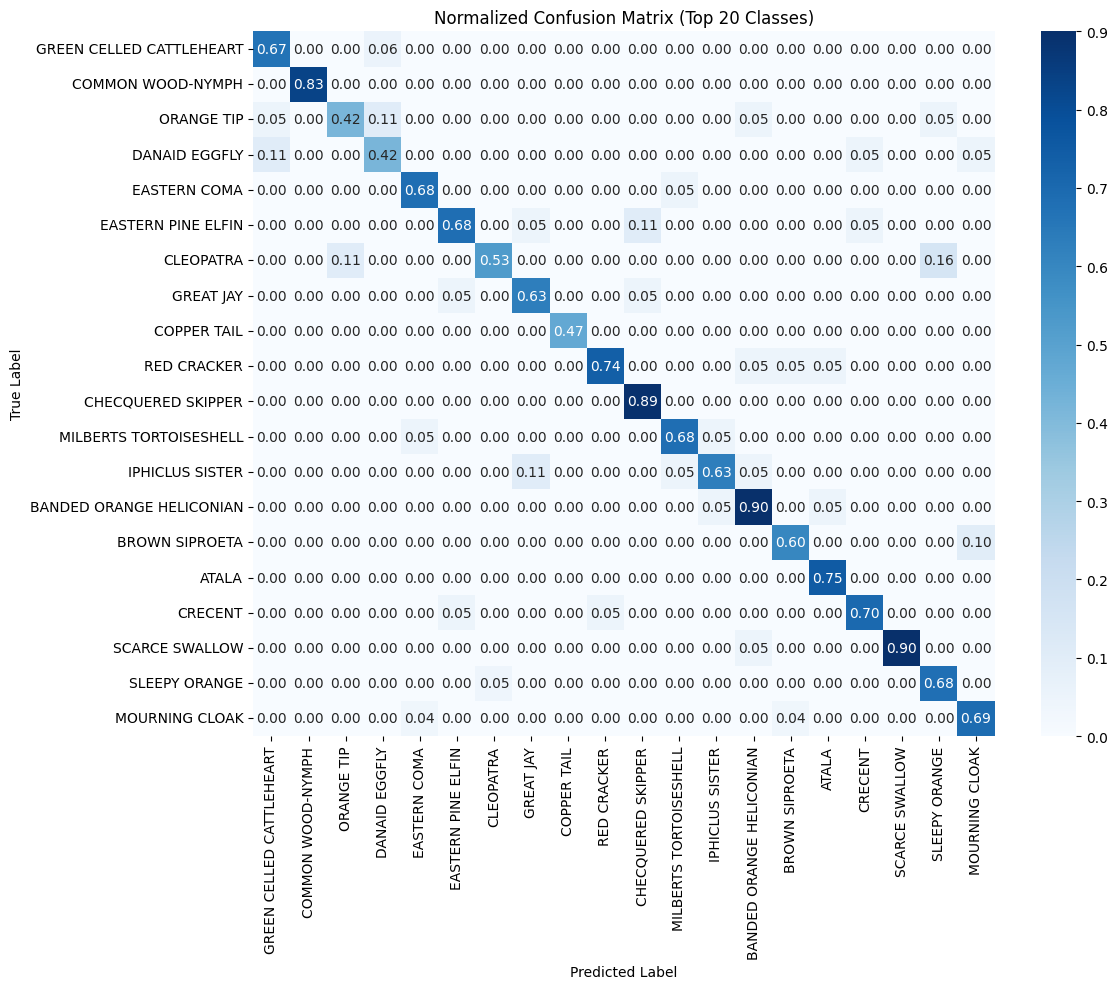

In [75]:
# Cell 20: Confusion Matrix for Validation Set
def plot_confusion_matrix(true_labels, pred_labels, class_names, normalize=True):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, pred_labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
        fmt = '.2f'
    else:
        title = 'Confusion Matrix'
        fmt = 'd'
    
    plt.figure(figsize=(12, 10))
    
    # For large number of classes, show a subset
    if len(class_names) > 20:
        # Show only top 20 classes by frequency
        class_counts = np.bincount(true_labels)
        top_classes_idx = np.argsort(class_counts)[-20:]
        
        # Filter confusion matrix
        cm_subset = cm[np.ix_(top_classes_idx, top_classes_idx)]
        class_names_subset = [class_names[i] for i in top_classes_idx]
        
        sns.heatmap(cm_subset, annot=True, fmt=fmt, cmap='Blues',
                   xticklabels=class_names_subset,
                   yticklabels=class_names_subset)
        plt.title(f'{title} (Top 20 Classes)')
    else:
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names)
        plt.title(title)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(val_true_classes, val_predicted_classes, classes)


In [76]:
# Cell 21: Test Set Predictions (if labels are available)
# Create test data generator (without labels for prediction)
class TestDataGenerator(keras.utils.Sequence):
    def __init__(self, dataframe, img_dir, batch_size, img_size):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.indices = np.arange(len(self.dataframe))
    
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.dataframe))
        batch_indices = self.indices[start_idx:end_idx]
        
        return self._generate_batch(batch_indices)
    
    def _generate_batch(self, batch_indices):
        batch_x = np.empty((len(batch_indices), self.img_size, self.img_size, 3))
        
        for i, idx in enumerate(batch_indices):
            row = self.dataframe.iloc[idx]
            
            # Load image
            img_path = os.path.join(self.img_dir, row['filename'])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img / 255.0
            
            batch_x[i] = img
        
        return batch_x

# Create test generator
test_generator = TestDataGenerator(test_df, TEST_IMG_DIR, BATCH_SIZE, IMG_SIZE)

# Generate predictions for test set
test_predictions = model.predict(test_generator, verbose=1)
test_predicted_classes = np.argmax(test_predictions, axis=1)
test_predicted_labels = [classes[idx] for idx in test_predicted_classes]

# Create submission dataframe
submission_df = test_df.copy()
submission_df['predicted_label'] = test_predicted_labels
submission_df['confidence'] = np.max(test_predictions, axis=1)

print(f"Test predictions generated for {len(submission_df)} images")
print("\nFirst 10 predictions:")
print(submission_df[['filename', 'predicted_label', 'confidence']].head(10))


44/44 ━━━━━━━━━━━━━━━━━━━━ 285s 6s/step
Test predictions generated for 2786 images

First 10 predictions:
       filename  predicted_label  confidence
0   Image_1.jpg   BROWN SIPROETA    0.236721
1   Image_2.jpg    CRIMSON PATCH    0.592203
2   Image_3.jpg  PURPLISH COPPER    0.621478
3   Image_4.jpg      RED POSTMAN    0.141447
4   Image_5.jpg  IPHICLUS SISTER    0.632066
5   Image_6.jpg  CLOUDED SULPHUR    0.527782
6   Image_7.jpg       PAPER KITE    0.532501
7   Image_8.jpg    INDRA SWALLOW    0.723051
8   Image_9.jpg      RED CRACKER    0.885748
9  Image_10.jpg  ZEBRA LONG WING    0.679637


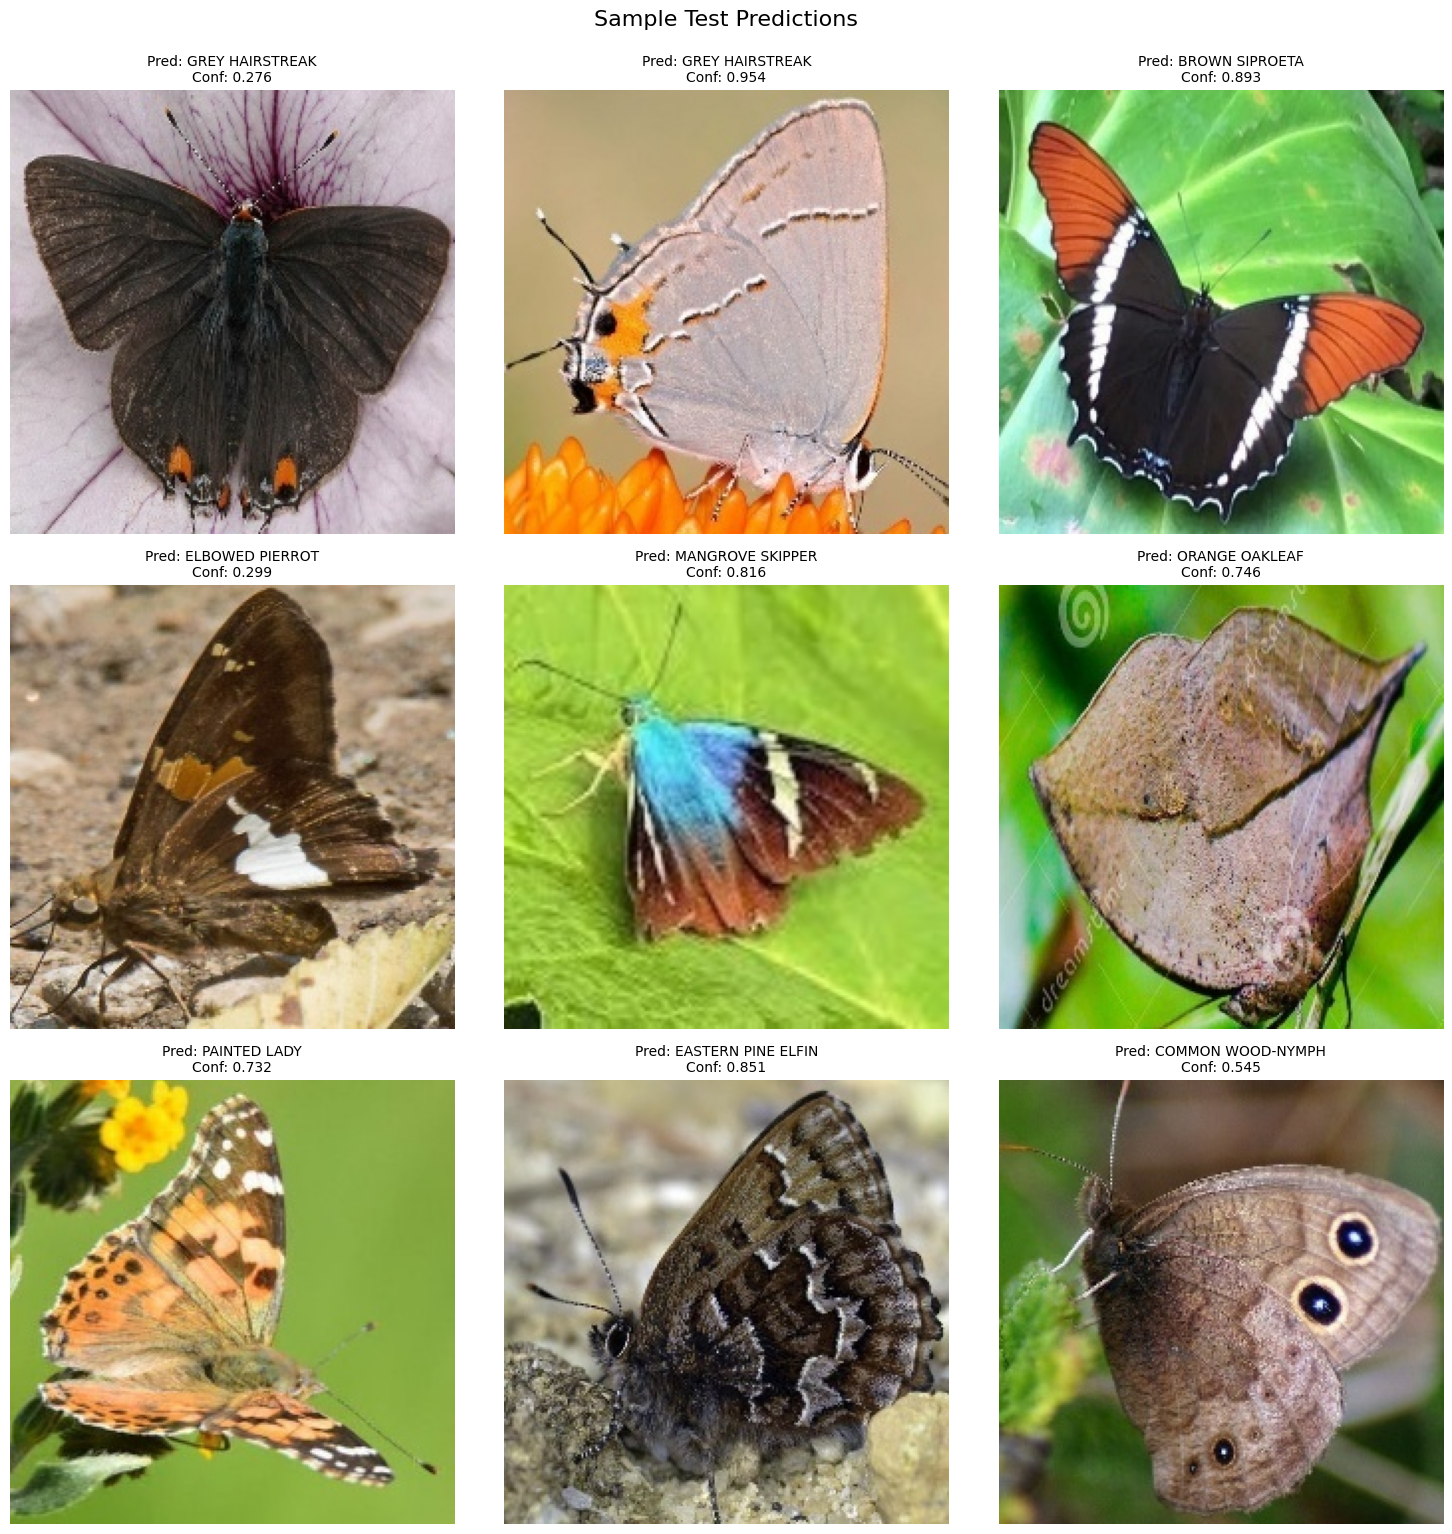

In [77]:
# Cell 22: Sample Test Predictions Visualization
def visualize_test_predictions(test_df, predictions, class_names, img_dir, num_samples=9):
    """Visualize sample test predictions"""
    indices = np.random.choice(len(test_df), num_samples, replace=False)
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        row = test_df.iloc[idx]
        img_path = os.path.join(img_dir, row['filename'])
        
        # Load and display image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get prediction
        pred_probs = predictions[idx]
        pred_label = np.argmax(pred_probs)
        pred_class = class_names[pred_label]
        confidence = pred_probs[pred_label]
        
        axes[i].imshow(img)
        axes[i].set_title(f'Pred: {pred_class}\nConf: {confidence:.3f}', fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample Test Predictions', fontsize=16, y=1.02)
    plt.show()

# Visualize test predictions
visualize_test_predictions(test_df, test_predictions, classes, TEST_IMG_DIR)


In [78]:
# Cell 23: Model Performance Summary
def create_performance_summary():
    """Create comprehensive performance summary"""
    summary = {
        'Model Architecture': 'EfficientNetB0 + Transfer Learning',
        'Dataset': 'Butterfly Image Classification (CSV-based)',
        'Number of Classes': num_classes,
        'Training Images': len(train_data),
        'Validation Images': len(val_data),
        'Test Images': len(test_df),
        'Image Size': f'{IMG_SIZE}x{IMG_SIZE}',
        'Batch Size': BATCH_SIZE,
        'Training Strategy': '2-Phase (Frozen + Fine-tuning)',
        'Validation Accuracy': f'{val_accuracy:.4f}',
        'Validation Top-5 Accuracy': f'{val_top5_accuracy:.4f}',
        'Validation Loss': f'{val_loss:.4f}'
    }
    
    print("=" * 50)
    print("MODEL PERFORMANCE SUMMARY")
    print("=" * 50)
    for key, value in summary.items():
        print(f"{key:.<30} {value}")
    print("=" * 50)
    
    return summary

# Display performance summary
performance_summary = create_performance_summary()


MODEL PERFORMANCE SUMMARY
Model Architecture............ EfficientNetB0 + Transfer Learning
Dataset....................... Butterfly Image Classification (CSV-based)
Number of Classes............. 75
Training Images............... 5199
Validation Images............. 1300
Test Images................... 2786
Image Size.................... 128x128
Batch Size.................... 64
Training Strategy............. 2-Phase (Frozen + Fine-tuning)
Validation Accuracy........... 0.6746
Validation Top-5 Accuracy..... 0.9069
Validation Loss............... 1.1969


In [79]:
# Cell 24: Save Model and Results
# Save final model
model.save('butterfly_classification_model.h5')
print("saved as 'butterfly_classification_model.h5'")


saved as 'butterfly_classification_model.h5'


In [80]:
# Save training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(combined_history, f)
print("Training history saved as 'training_history.pkl'")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved as 'label_encoder.pkl'")

# Save class names
with open('class_names.pkl', 'wb') as f:
    pickle.dump(classes, f)
print("Class names saved as 'class_names.pkl'")

# Save test predictions
submission_df.to_csv('test_predictions.csv', index=False)
print("Test predictions saved as 'test_predictions.csv'")

# Save performance summary
import json
with open('performance_summary.json', 'w') as f:
    json.dump(performance_summary, f, indent=2)
print("Performance summary saved as 'performance_summary.json'")


Training history saved as 'training_history.pkl'
Label encoder saved as 'label_encoder.pkl'
Class names saved as 'class_names.pkl'
Test predictions saved as 'test_predictions.csv'
Performance summary saved as 'performance_summary.json'


In [81]:
print("\n" + "="*50)
print("BUTTERFLY CLASSIFICATION PROJECT COMPLETED!")
print("="*50)
print(f"Final Validation Accuracy: {val_accuracy:.2%}")
print(f"Test predictions generated for {len(test_df)} images")
print(f"Model files saved successfully!")
print("="*50)


BUTTERFLY CLASSIFICATION PROJECT COMPLETED!
Final Validation Accuracy: 67.46%
Test predictions generated for 2786 images
Model files saved successfully!
